# Lending Club Default Risk

This notebook is an end-to-end workflow for predicting loan default risk using Lending Club's accepted loan data.

In [18]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
from IPython.display import display

from sklearn.base import clone
from sklearn.metrics import accuracy_score, average_precision_score, f1_score, fbeta_score, roc_auc_score, confusion_matrix, precision_score, recall_score
from src.config import (
    ARTIFACT_DIR,
    CONFIG,
    MODEL_FEATURES,
    RAW_FEATURES,
    get_accepted_data_path,
)
from src.pipeline import (
    compute_scale_pos_weight,
    prepare_model_dataset,
    run_lightgbm_random_search,
    run_random_search,
    time_based_split,
)
from src.reporting import (
    apply_threshold,
    compute_shap_importances,
    confusion_matrix_dataframe,
    evaluate_split,
    permutation_importance_summary,
    pick_threshold_by_fbeta,
    plot_diagnostics,
    save_best_params,
    save_feature_importances,
    save_metrics,
    save_pipeline,
    save_predictions,
)

sns.set_theme(style="whitegrid")
warnings.filterwarnings("ignore", category=UserWarning)
plt.rcParams["figure.figsize"] = (10, 6)
np.random.seed(CONFIG["random_state"])


## Load & Inspect Data

In [19]:
pd.set_option('display.max_columns', None)

In [20]:
accepted_path = get_accepted_data_path()
print(f"Accepted data source: {accepted_path}")

df_raw = pd.read_csv(
    accepted_path,
    usecols=RAW_FEATURES,
    low_memory=False,
)

print(f"Raw shape: {df_raw.shape}")
display(df_raw.head())
print("Loan status counts:")
display(df_raw['loan_status'].value_counts().to_frame(name='count'))


Accepted data source: /Users/yuanhaowen/Desktop/Project/LoanDefaultPredictor/data/accepted_2007_to_2018Q4.csv
Raw shape: (2260701, 36)


,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,application_type,tot_cur_bal,total_rev_hi_lim,chargeoff_within_12_mths,mort_acc,mths_since_recent_inq,pub_rec_bankruptcies,tax_liens
0,3600.0,36 months,13.99,123.03,C,C4,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,Fully Paid,debt_consolidation,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,7.0,0.0,2765.0,29.7,13.0,564.0,560.0,0.0,Individual,144904.0,9300.0,0.0,1.0,4.0,0.0,0.0
1,24700.0,36 months,11.99,820.28,C,C1,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Fully Paid,small_business,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,22.0,0.0,21470.0,19.2,38.0,699.0,695.0,0.0,Individual,204396.0,111800.0,0.0,4.0,0.0,0.0,0.0
2,20000.0,60 months,10.78,432.66,B,B4,10+ years,MORTGAGE,63000.0,Not Verified,Dec-2015,Fully Paid,home_improvement,IL,10.78,0.0,Aug-2000,695.0,699.0,0.0,6.0,0.0,7869.0,56.2,18.0,704.0,700.0,0.0,Joint App,189699.0,14000.0,0.0,5.0,10.0,0.0,0.0
3,35000.0,60 months,14.85,829.90,C,C5,10+ years,MORTGAGE,110000.0,Source Verified,Dec-2015,Current,debt_consolidation,NJ,17.06,0.0,Sep-2008,785.0,789.0,0.0,13.0,0.0,7802.0,11.6,17.0,679.0,675.0,0.0,Individual,301500.0,67300.0,0.0,1.0,NaN,0.0,0.0
4,10400.0,60 months,22.45,289.91,F,F1,3 years,MORTGAGE,104433.0,Source Verified,Dec-2015,Fully Paid,major_purchase,PA,25.37,1.0,Jun-1998,695.0,699.0,3.0,12.0,0.0,21929.0,64.5,35.0,704.0,700.0,0.0,Individual,331730.0,34000.0,0.0,6.0,1.0,0.0,0.0


Loan status counts:


,count
loan_status,
Fully Paid,1076751
Current,878317
Charged Off,268559
Late (31-120 days),21467
In Grace Period,8436
Late (16-30 days),4349
Does not meet the credit policy. Status:Fully Paid,1988
Does not meet the credit policy. Status:Charged Off,761
Default,40


## Clean & Engineer Features

In [21]:
df_model = prepare_model_dataset(df_raw)
print(f"Model dataset shape: {df_model.shape}")

class_counts = df_model[CONFIG["target_column"]].value_counts().rename("count")
class_props = df_model[CONFIG["target_column"]].value_counts(normalize=True).rename("proportion")
display(pd.concat([class_counts, class_props], axis=1))
display(df_model.head())

/Users/yuanhaowen/Desktop/Project/LoanDefaultPredictor/src/pipeline.py:95: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["installment_to_income_ratio"].replace([np.inf, -np.inf], np.nan, inplace=True)


Model dataset shape: (1366817, 32)


,count,proportion
is_default,,
0.0,1076751,0.78778
1.0,290066,0.21222


,loan_amnt,term_months,int_rate_decimal,installment,emp_length_years,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util_decimal,total_acc,collections_12_mths_ex_med,chargeoff_within_12_mths,pub_rec_bankruptcies,tax_liens,fico_average,credit_history_years,installment_to_income_ratio,mths_since_recent_inq,mort_acc,tot_cur_bal,total_rev_hi_lim,home_ownership,verification_status,purpose,addr_state,application_type,issue_d,is_default
0,7500.0,36.0,0.1375,255.43,0.5,22000.0,14.29,1.0,0.0,7.0,0.0,4175.0,0.515,8.0,NaN,NaN,NaN,NaN,662.0,3.665982,0.139325,NaN,NaN,NaN,NaN,OWN,Not Verified,debt_consolidation,MA,Individual,2007-06,0.0
1,3500.0,36.0,0.1028,113.39,0.5,20000.0,1.50,0.0,0.0,17.0,0.0,1882.0,0.324,18.0,NaN,NaN,NaN,0.0,682.0,3.830253,0.068034,NaN,NaN,NaN,NaN,RENT,Not Verified,moving,MA,Individual,2007-07,0.0
2,5750.0,36.0,0.0743,178.69,10.0,125000.0,0.27,0.0,0.0,10.0,0.0,2817.0,0.102,16.0,NaN,NaN,NaN,NaN,792.0,20.495551,0.017154,NaN,NaN,NaN,NaN,MORTGAGE,Not Verified,debt_consolidation,MA,Individual,2007-07,0.0
3,5000.0,36.0,0.0743,155.38,6.0,40000.0,2.55,0.0,2.0,4.0,0.0,2562.0,0.140,7.0,NaN,NaN,NaN,0.0,772.0,22.409309,0.046614,NaN,NaN,NaN,NaN,RENT,Not Verified,car,WI,Individual,2007-07,0.0
4,1200.0,36.0,0.1154,39.60,0.5,20000.0,2.04,0.0,2.0,3.0,0.0,1153.0,0.758,4.0,NaN,NaN,NaN,NaN,662.0,3.164956,0.023760,NaN,NaN,NaN,NaN,RENT,Not Verified,credit_card,ME,Individual,2007-07,0.0


In [22]:
missing_ratio = df_model[MODEL_FEATURES].isna().mean().sort_values(ascending=False)
display(missing_ratio.to_frame("missing_ratio"))

,missing_ratio
mths_since_recent_inq,1.286383e-01
emp_length_years,5.879865e-02
total_rev_hi_lim,4.940457e-02
tot_cur_bal,4.940457e-02
mort_acc,3.459205e-02
revol_util_decimal,6.467581e-04
pub_rec_bankruptcies,5.099439e-04
dti,2.911875e-04
installment_to_income_ratio,2.809447e-04
collections_12_mths_ex_med,4.097110e-05


## Train/Validation/Test Split

In [23]:
splits, cutoffs = time_based_split(df_model)
train_df, val_df, test_df = splits["train"], splits["val"], splits["test"]

print("Split sizes:")
print({k: len(v) for k, v in splits.items()})
print("Date cutoffs:")
print(cutoffs)

if CONFIG["max_training_rows"] and len(train_df) > CONFIG["max_training_rows"]:
    train_df = train_df.iloc[-CONFIG["max_training_rows"]:].reset_index(drop=True)
    print(f"Training set truncated to last {len(train_df)} rows for efficiency.")

X_train = train_df[MODEL_FEATURES]
y_train = train_df[CONFIG["target_column"]]
X_val = val_df[MODEL_FEATURES]
y_val = val_df[CONFIG["target_column"]]
X_test = test_df[MODEL_FEATURES]
y_test = test_df[CONFIG["target_column"]]

train_val_df = pd.concat([train_df, val_df], axis=0).sort_values(CONFIG["date_column"]).reset_index(drop=True)
X_train_val = train_val_df[MODEL_FEATURES]
y_train_val = train_val_df[CONFIG["target_column"]]

scale_pos_weight = compute_scale_pos_weight(y_train.to_numpy())
CONFIG["model_params"]["scale_pos_weight"] = scale_pos_weight
CONFIG["lightgbm_params"]["scale_pos_weight"] = scale_pos_weight
print(f"Positive rate (train): {y_train.mean():.4f} | scale_pos_weight: {scale_pos_weight:.2f}")


Split sizes:
{'train': 956771, 'val': 205023, 'test': 205023}
Date cutoffs:
{'train_end': Period('2016-04', 'M'), 'val_end': Period('2017-03', 'M'), 'test_end': Period('2018-12', 'M')}
Training set truncated to last 600000 rows for efficiency.
Positive rate (train): 0.2055 | scale_pos_weight: 3.87


## Hyperparameter Search

In [24]:
CONFIG["tuning_sample_size"] = 300000

In [25]:
tune_df = train_df.copy()
if CONFIG["tuning_sample_size"] and len(tune_df) > CONFIG["tuning_sample_size"]:
    tune_df = tune_df.iloc[-CONFIG["tuning_sample_size"]:]
    print(f"Tuning sample reduced to last {len(tune_df)} rows to speed up search.")

X_tune = tune_df[MODEL_FEATURES]
y_tune = tune_df[CONFIG["target_column"]]


Tuning sample reduced to last 300000 rows to speed up search.


In [26]:
MODEL_RUNNERS = {
    "xgboost": run_random_search,
    "lightgbm": run_lightgbm_random_search,
}

search_results = {}

for model_name, run_search in MODEL_RUNNERS.items():
    print(f"\n--- Tuning {model_name.upper()} ---")

    search_result = run_search(
        X_tune,
        y_tune,
        scale_pos_weight=scale_pos_weight,
    )

    print(f"Best ROC-AUC: {search_result.best_score_:.4f}")
    print("Best hyperparameters:")
    print(search_result.best_params_)

    search_results[model_name] = search_result



--- Tuning XGBOOST ---
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Best ROC-AUC: 0.7431
Best hyperparameters:
{'classifier__subsample': 0.6, 'classifier__reg_lambda': 0.5, 'classifier__reg_alpha': 0.0, 'classifier__n_estimators': 400, 'classifier__min_child_weight': 5, 'classifier__max_depth': 6, 'classifier__learning_rate': 0.03, 'classifier__gamma': 0.3, 'classifier__colsample_bytree': 0.6}

--- Tuning LIGHTGBM ---
Fitting 3 folds for each of 15 candidates, totalling 45 fits


/Users/yuanhaowen/anaconda3/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
/Users/yuanhaowen/anaconda3/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
/Users/yuanhaowen/anaconda3/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or 

[LightGBM] [Info] Number of positive: 15262, number of negative: 59738
[LightGBM] [Info] Number of positive: 15262, number of negative: 59738
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007091 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006540 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3043
[LightGBM] [Info] Number of data points in the train set: 75000, number of used features: 92
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203493 -> initscore=-1.364602
[LightGBM] [Info] Start training from score -1.364602
[LightGBM] [Info] Total Bins 3043
[LightGBM] [Info] Number of data points in the train set: 75000, number of used features: 92
[LightGBM] [Info] 

## Final Training on Train+Validation

In [27]:
model_registry = {}
for model_name, search in search_results.items():
    print(f"Refitting {model_name.upper()} on combined train + validation data...")
    pipeline_model = clone(search.best_estimator_)
    pipeline_model.fit(X_train_val, y_train_val)
    model_registry[model_name] = {
        "pipeline": pipeline_model,
        "search": search,
        "cv_best_score": search.best_score_,
    }
    print(f"Trained {model_name} pipeline on combined train + validation data.")

Refitting XGBOOST on combined train + validation data...
Trained xgboost pipeline on combined train + validation data.
Refitting LIGHTGBM on combined train + validation data...
[LightGBM] [Info] Number of positive: 177259, number of negative: 627764
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020046 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3233
[LightGBM] [Info] Number of data points in the train set: 805023, number of used features: 96
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220191 -> initscore=-1.264552
[LightGBM] [Info] Start training from score -1.264552
Trained lightgbm pipeline on combined train + validation data.


## 6. Evaluation

In [28]:
model_artifacts = {}
best_thresholds = {}

for model_name, registry in model_registry.items():
    pipeline_model = registry["pipeline"]

    metrics_summary = {}
    probabilities_store = {}  
    predictions_store = {}

    for label, X_split, y_split in [
        ("train", X_train, y_train),
        ("validation", X_val, y_val),
        ("test", X_test, y_test),
    ]:
        proba = pipeline_model.predict_proba(X_split)[:, 1]
        probabilities_store[label] = proba

        metrics_summary[label] = {
            "roc_auc": roc_auc_score(y_split, proba),
            "average_precision": average_precision_score(y_split, proba),
            "pos_rate": float(np.mean(y_split)),  
        }

    val_proba = probabilities_store["validation"]
    best_th, best_f1, best_p, best_r = pick_threshold_by_fbeta(
        y_val, val_proba, beta=1.0
    )

    best_thresholds[model_name] = {
        "threshold": best_th,
        "precision": best_p,
        "recall": best_r,
        "f1": best_f1,
        "beta": 1.0,
    }

    print(
        f"\nBest threshold for {model_name} (F1): {best_th:.3f} "
        f"| val_P={best_p:.3f} val_R={best_r:.3f} val_F1={best_f1:.3f}"
    )

    test_proba = probabilities_store["test"]
    test_preds_thresh = apply_threshold(test_proba, best_th)
    predictions_store["test_thresholded"] = test_preds_thresh 

    tn, fp, fn, tp = confusion_matrix(y_test, test_preds_thresh).ravel()
    metrics_summary["test_thresholded"] = {
        "threshold": best_th,
        "precision": precision_score(y_test, test_preds_thresh),
        "recall": recall_score(y_test, test_preds_thresh),
        "f1": f1_score(y_test, test_preds_thresh),
        "pred_pos_rate": float(np.mean(test_preds_thresh)),
        "tn": int(tn), "fp": int(fp), "fn": int(fn), "tp": int(tp),
        # 
        
        "roc_auc": roc_auc_score(y_test, test_proba),
        "average_precision": average_precision_score(y_test, test_proba),
    }

    print(f"\nMetrics summary for {model_name.upper()} (trimmed):")
    display(pd.DataFrame.from_dict(metrics_summary, orient="index"))

    model_artifacts[model_name] = {
        "metrics": metrics_summary,
        "probabilities": probabilities_store,
        "predictions": predictions_store,  
        "best_threshold": best_thresholds[model_name],
    }



Best threshold for xgboost (F1): 0.520 | val_P=0.394 val_R=0.703 val_F1=0.505

Metrics summary for XGBOOST (trimmed):


,roc_auc,average_precision,pos_rate,threshold,precision,recall,f1,pred_pos_rate,tn,fp,fn,tp
train,0.750504,0.441861,0.205475,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
validation,0.717227,0.466232,0.263258,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
test,0.713810,0.456929,0.264619,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
test_thresholded,0.713810,0.456929,NaN,0.519561,0.398638,0.677714,0.501997,0.449871,95304.0,55466.0,17485.0,36768.0



Best threshold for lightgbm (F1): 0.526 | val_P=0.391 val_R=0.698 val_F1=0.501

Metrics summary for LIGHTGBM (trimmed):


,roc_auc,average_precision,pos_rate,threshold,precision,recall,f1,pred_pos_rate,tn,fp,fn,tp
train,0.747306,0.435599,0.205475,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
validation,0.711764,0.456746,0.263258,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
test,0.711975,0.452508,0.264619,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
test_thresholded,0.711975,0.452508,NaN,0.526054,0.397168,0.676313,0.500447,0.450603,95078.0,55692.0,17561.0,36692.0


In [29]:
def bucket_monotonicity(y_true, pd_pred, n_bins=10):
    df = pd.DataFrame({"y": y_true, "pd": pd_pred})
    df["bin"] = pd.qcut(df["pd"], q=n_bins, duplicates="drop")
    grouped = df.groupby("bin").agg(
        count=("y", "size"),
        bad_rate=("y", "mean"),
        pd_mean=("pd", "mean"),
    ).reset_index()
    return grouped

val_table = bucket_monotonicity(y_val, model_artifacts["xgboost"]["probabilities"]["validation"], n_bins=10)
print(val_table)


is_monotone = val_table["bad_rate"].is_monotonic_increasing
print("Monotone increasing bad rate:", is_monotone)


               bin  count  bad_rate   pd_mean
0  (0.0299, 0.232]  20503  0.050724  0.158530
1   (0.232, 0.324]  20502  0.102380  0.281449
2   (0.324, 0.392]  20502  0.144279  0.358891
3    (0.392, 0.45]  20502  0.190372  0.421332
4    (0.45, 0.504]  20503  0.222504  0.477208
5   (0.504, 0.556]  20502  0.265438  0.529974
6    (0.556, 0.61]  20502  0.314311  0.582583
7    (0.61, 0.671]  20502  0.361428  0.639667
8    (0.671, 0.75]  20502  0.425666  0.709233
9    (0.75, 0.937]  20503  0.555480  0.806534
Monotone increasing bad rate: True


/var/folders/_h/v3zx4l357d3fgz8svznhxcjc0000gn/T/ipykernel_35615/4200565979.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby("bin").agg(


In [30]:
# model_artifacts = {}
# best_thresholds = {}

# for model_name, registry in model_registry.items():
#     pipeline_model = registry["pipeline"]
#     metrics_summary = {}
#     predictions_store = {}
#     probabilities_store = {}

#     for label, X_split, y_split in [
#         ("train", X_train, y_train),
#         ("validation", X_val, y_val),
#         ("test", X_test, y_test),
#     ]:
#         metrics, preds, proba = evaluate_split(
#             pipeline_model,
#             X_split,
#             y_split,
#             f"{model_name}-{label}",
#             threshold=None,
#             fbeta_beta=1.0,
#         )
#         metrics_summary[label] = metrics
#         predictions_store[label] = preds
#         probabilities_store[label] = proba

#     val_proba = probabilities_store["validation"]
#     best_th, best_fbeta, best_p, best_r = pick_threshold_by_fbeta(
#         y_val,
#         val_proba,
#         beta=1.0,
#     )
#     best_thresholds[model_name] = {
#         "threshold": best_th,
#         "precision": best_p,
#         "recall": best_r,
#         "fbeta": best_fbeta,
#         "beta": 1.0,
#     }

#     test_proba = probabilities_store["test"]
#     test_preds_thresh = apply_threshold(test_proba, best_th)
#     metrics_summary["test_thresholded"] = {
#         "roc_auc": roc_auc_score(y_test, test_proba),
#         "average_precision": average_precision_score(y_test, test_proba),
#         "accuracy": accuracy_score(y_test, test_preds_thresh),
#         "f1": f1_score(y_test, test_preds_thresh),
#         "f_beta": fbeta_score(y_test, test_preds_thresh, beta=1.0),
#     }
#     predictions_store["test_thresholded"] = test_preds_thresh

#     print(
#         f"\nBest threshold for {model_name} (beta=1): "
#         f"{best_th:.3f} | val_P={best_p:.3f} val_R={best_r:.3f}"
#     )

#     print(f"\nMetrics summary for {model_name.upper()}:")
#     display(pd.DataFrame.from_dict(metrics_summary, orient="index"))

#     model_artifacts[model_name] = {
#         "metrics": metrics_summary,
#         "predictions": predictions_store,
#         "probabilities": probabilities_store,
#     }

Confusion matrix for XGBOOST (test, test_thresholded):


,Pred_0,Pred_1
Actual_0,95304,55466
Actual_1,17485,36768


Diagnostic curves for XGBOOST (test):


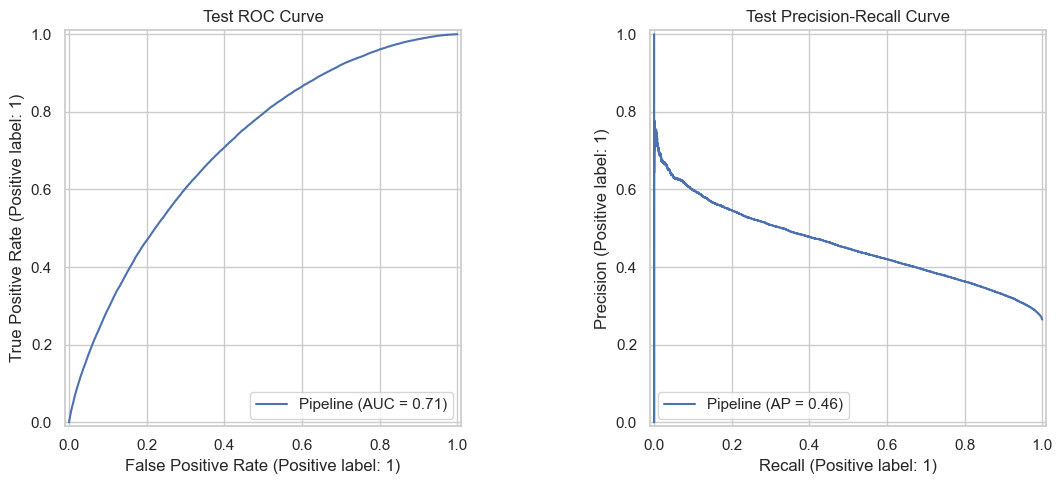

Confusion matrix for LIGHTGBM (test, test_thresholded):


,Pred_0,Pred_1
Actual_0,95078,55692
Actual_1,17561,36692


Diagnostic curves for LIGHTGBM (test):


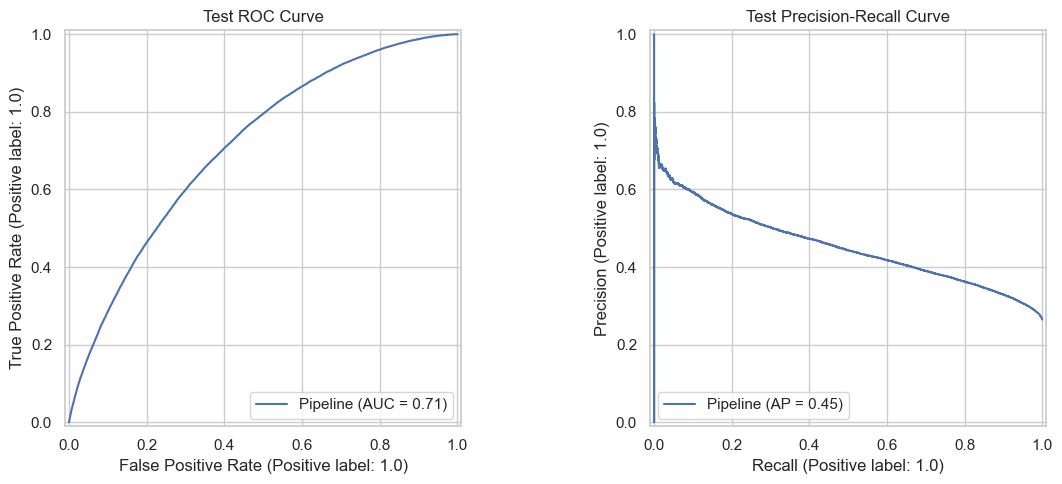

In [31]:
for model_name, registry in model_registry.items():
    preds_key = "test_thresholded" if "test_thresholded" in model_artifacts[model_name]["predictions"] else "test"
    test_preds = model_artifacts[model_name]["predictions"][preds_key]
    cm_df = confusion_matrix_dataframe(y_test, test_preds)
    print(f"Confusion matrix for {model_name.upper()} (test, {preds_key}):")
    display(cm_df)
    print(f"Diagnostic curves for {model_name.upper()} (test):")
    plot_diagnostics(registry["pipeline"], X_test, y_test)


## 7. Feature Importance & Interpretation

Best model by test ROC-AUC: xgboost


,mean_importance
int_rate_decimal,0.065465
term_months,0.013675
dti,0.009157
fico_average,0.008662
addr_state,0.008161
emp_length_years,0.006582
home_ownership,0.005553
open_acc,0.005478
tot_cur_bal,0.005001
mort_acc,0.004802


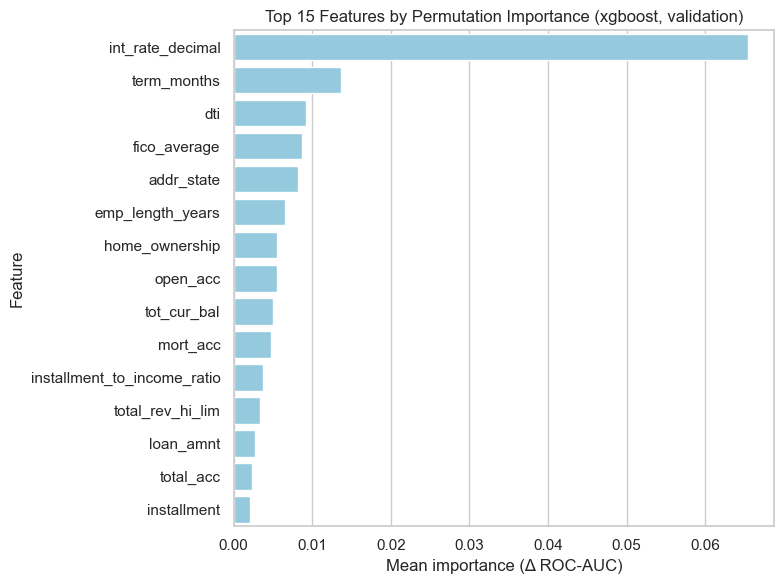

In [32]:
# Permutation Importance
best_model_name = max(
    model_artifacts.keys(),
    key=lambda name: model_artifacts[name]["metrics"]["test"]["roc_auc"]
)
best_pipeline = model_registry[best_model_name]["pipeline"]
print(f"Best model by test ROC-AUC: {best_model_name}")

perm_series = permutation_importance_summary(best_pipeline, X_val, y_val)
display(perm_series.to_frame("mean_importance"))

plt.figure(figsize=(8, 6))
sns.barplot(
    x=perm_series.head(15),
    y=perm_series.head(15).index,
    orient="h",
    color="skyblue",
)
plt.title(f"Top 15 Features by Permutation Importance ({best_model_name}, validation)")
plt.xlabel("Mean importance (Δ ROC-AUC)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

Top SHAP importances for xgboost


int_rate_decimal               0.489805
term_months                    0.229030
fico_average                   0.144715
dti                            0.121011
open_acc                       0.094046
tot_cur_bal                    0.071766
mort_acc                       0.071493
installment_to_income_ratio    0.060878
emp_length_years               0.059425
total_rev_hi_lim               0.048030
loan_amnt                      0.046088
mths_since_recent_inq          0.042131
inq_last_6mths                 0.030517
total_acc                      0.029267
installment                    0.026298
home                           0.023640
revol_bal                      0.023007
verification                   0.016155
annual_inc                     0.015584
credit_history_years           0.014854
dtype: float32

/var/folders/_h/v3zx4l357d3fgz8svznhxcjc0000gn/T/ipykernel_35615/4252779487.py:9: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


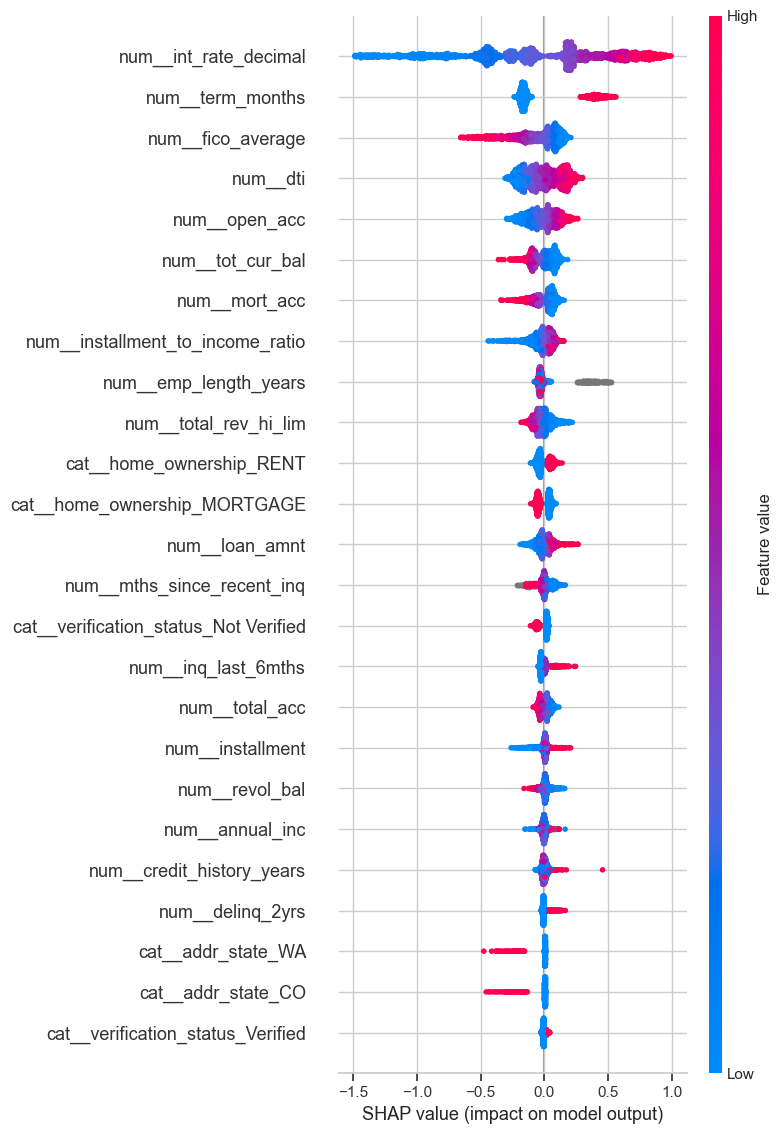

In [33]:
shap_agg_df = None
if CONFIG["enable_shap"]:
    try:
        shap_agg_df, shap_values, shap_transformed, shap_feature_names = compute_shap_importances(
            best_pipeline, X_test
        )
        print(f"Top SHAP importances for {best_model_name}")
        display(shap_agg_df.head(20))
        shap.summary_plot(
            shap_values,
            features=shap_transformed,
            feature_names=shap_feature_names,
            max_display=25,
        )
    except Exception as exc:
        shap_agg_df = None
        print(f"SHAP analysis skipped for {best_model_name}: {exc}")
else:
    print("SHAP analysis disabled via CONFIG['enable_shap'].")


## 8. Export Resluts

In [34]:
# metrics_payload = {}
# for model_name, artifacts in model_artifacts.items():
#     metrics_payload[model_name] = {
#         split: {metric: float(value) for metric, value in scores.items()}
#         for split, scores in artifacts["metrics"].items()
#     }
#     metrics_payload[model_name]["threshold"] = best_thresholds.get(model_name, {})

# best_params_payload = {
#     name: {
#         **registry["search"].best_params_,
#         "best_threshold": best_thresholds[name]["threshold"],
#         "best_threshold_beta": best_thresholds[name]["beta"],
#     }
#     for name, registry in model_registry.items()
# }

# paths = {
#     "metrics": save_metrics(metrics_payload),
#     "best_params": save_best_params(best_params_payload),
# }

# for model_name, artifacts in model_artifacts.items():
#     test_probs = artifacts["probabilities"]["test"]
#     threshold = best_thresholds[model_name]["threshold"]
#     test_preds = artifacts["predictions"].get("test_thresholded", apply_threshold(test_probs, threshold))

#     predictions_export = test_df[[CONFIG["date_column"], CONFIG["target_column"]]].copy()
#     predictions_export["predicted_label"] = test_preds
#     predictions_export["predicted_probability"] = test_probs
#     paths[f"{model_name}_predictions"] = save_predictions(
#         predictions_export,
#         filename=f"test_predictions_{model_name}.csv",
#     )
#     paths[f"{model_name}_pipeline"] = save_pipeline(
#         model_registry[model_name]["pipeline"],
#         filename=f"{model_name}_pipeline.joblib",
#     )

# paths["permutation_importances"] = save_feature_importances(
#     perm_series.rename("permutation_importance"),
#     filename=f"feature_importances_permutation_{best_model_name}.csv",
# )

# if shap_agg_df is not None:
#     paths["shap_importances"] = save_feature_importances(
#         shap_agg_df.rename("mean_abs_shap"),
#         filename=f"feature_importances_shap_{best_model_name}.csv",
#     )

# print("Artifacts saved:")
# for name, path in paths.items():
#     print(f" - {name}: {path}")
